In [1]:
import os
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.layers import Flatten, Dense, Input, Dropout, Rescaling
from tensorflow.keras.models import Model

In [2]:
notebook_path = os.path.dirname(os.path.abspath('brain_MRI_classification.ipynb'))
datasets_combined = os.path.join(notebook_path, 'brainMRI_data')

train_directory = os.path.join(datasets_combined, 'Training')
test_directory = os.path.join(datasets_combined, 'Testing')

In [48]:
BATCH_SIZE = 64
IMG_SIZE = (224, 224)

train_dataset = image_dataset_from_directory(train_directory,
                                             batch_size = BATCH_SIZE,
                                             image_size = IMG_SIZE,
                                             shuffle = True,
                                             validation_split = 0.2,
                                             subset = 'training',
                                             seed = 42,
                                             label_mode='categorical')

validation_dataset = image_dataset_from_directory(train_directory,
                                                  batch_size = BATCH_SIZE,
                                                  image_size = IMG_SIZE,
                                                  shuffle = True,
                                                  validation_split = 0.2,
                                                  subset = 'validation',
                                                  seed = 42,
                                                  label_mode='categorical')

Found 2870 files belonging to 4 classes.
Using 2296 files for training.
Found 2870 files belonging to 4 classes.
Using 574 files for validation.


In [49]:
test_dataset = image_dataset_from_directory(test_directory,
                                            shuffle = False,
                                            image_size = IMG_SIZE,
                                            label_mode='categorical')

Found 394 files belonging to 4 classes.


In [50]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [55]:
# (224, 224) -> (224, 224, 3) for the 3 color channels
IMG_SHAPE = IMG_SIZE + (3,)

# load network without the top classification layers
base_model = VGG19(include_top = False,
                   weights = 'imagenet',
                   input_shape=IMG_SHAPE)

In [56]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.1),
])

In [57]:
# only augment training set
train_augmented = train_dataset.map(lambda x, y: (data_augmentation(x, training = False), y))

In [58]:
preprocess_input = tf.keras.applications.vgg19.preprocess_input

In [59]:
base_model.trainable = False

inputs = tf.keras.Input(shape=IMG_SHAPE)
x = preprocess_input(inputs)
x = base_model(x, training=False)

# Flatten the output layer to 1D
x = Flatten()(x)

# Add a fully connected layer with 4096 hidden units, ReLU activation
x = Dense(4096, activation = 'relu')(x)

# Add a dropout layer with 0.2 (20%) rate
x = Dropout(0.2)(x) 

# Add another FC layer, 4096 units, ReLU activation
x = Dense(4096, activation = 'relu')(x)

# Add another dropout layer with 0.2 (20%) rate
x = Dropout(0.2)(x) 

# Add a final FC layer for classification with 4 units using softmax activation function
outputs = Dense(4, activation = 'softmax')(x)

# Configure and compile the model
model1 = Model(inputs, outputs)
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Done compiling the model!


In [60]:
model1.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_4  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_4 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_4 (Flatten)         (None, 25088)             0         
                                                                 
 dense_12 (Dense)            (None, 4096)              1027

In [61]:
results1 = model1.fit(
    train_augmented,
    epochs = 20,
    validation_data = validation_dataset,
    verbose = 1)

Epoch 1/20
36/36 [==============================] - 366s 10s/step - loss: 43.8868 - accuracy: 0.6533 - val_loss: 0.4414 - val_accuracy: 0.8624
Epoch 2/20
36/36 [==============================] - 422s 12s/step - loss: 0.5199 - accuracy: 0.8554 - val_loss: 0.6641 - val_accuracy: 0.8415
Epoch 3/20
36/36 [==============================] - 431s 12s/step - loss: 0.2634 - accuracy: 0.9264 - val_loss: 0.3403 - val_accuracy: 0.8955
Epoch 4/20
36/36 [==============================] - 431s 12s/step - loss: 0.1836 - accuracy: 0.9521 - val_loss: 0.2891 - val_accuracy: 0.8990
Epoch 5/20
36/36 [==============================] - 433s 12s/step - loss: 0.1134 - accuracy: 0.9656 - val_loss: 0.4765 - val_accuracy: 0.9024
Epoch 6/20
36/36 [==============================] - 434s 12s/step - loss: 0.1731 - accuracy: 0.9608 - val_loss: 0.4318 - val_accuracy: 0.9024
Epoch 7/20
36/36 [==============================] - 441s 12s/step - loss: 0.1316 - accuracy: 0.9682 - val_loss: 0.3579 - val_accuracy: 0.9059
Epoch

In [84]:
print(results1.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


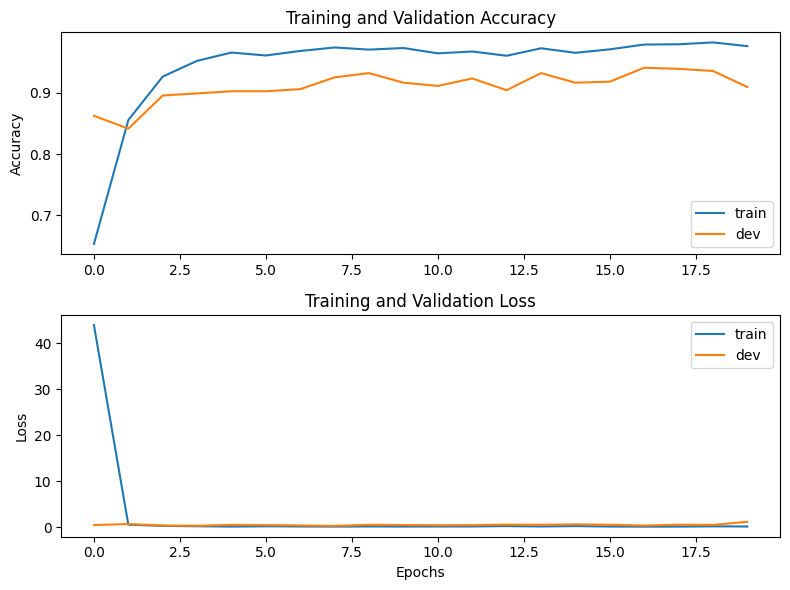

In [85]:
acc = results1.history['accuracy']
val_acc = results1.history['val_accuracy']

loss = results1.history['loss']
val_loss = results1.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(8,6))
plt.subplot(2,1,1)
plt.plot(epochs, acc, label="train")
plt.plot(epochs, val_acc, label="dev")
plt.ylabel("Accuracy")
plt.title('Training and Validation Accuracy')
plt.legend(loc="lower right")

plt.subplot(2,1,2)
plt.plot(epochs, loss, label="train")
plt.plot(epochs, val_loss, label="dev")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Training and Validation Loss')
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()


In [97]:
base_model.trainable = False

inputs = tf.keras.Input(shape=IMG_SHAPE)
x = preprocess_input(inputs)
x = base_model(x, training=False)

# Flatten the output layer to 1D
x = Flatten()(x)

# Add a fully connected layer with 4096 hidden units, ReLU activation
x = Dense(4096, activation = 'relu')(x)

# Add a dropout layer with 0.2 (20%) rate
x = Dropout(0.2)(x) 

# Add another FC layer, 4096 units, ReLU activation
x = Dense(4096, activation = 'relu')(x)

# Add another dropout layer with 0.2 (20%) rate
x = Dropout(0.5)(x) 

# Add a final FC layer for classification with 4 units using softmax activation function
outputs = Dense(4, activation = 'softmax')(x)

# Configure and compile the model
model_second = Model(inputs, outputs)
model_second.compile(loss='categorical_crossentropy',
                   optimizer='adam',
                   metrics=['accuracy'])

In [98]:
results_second = model_second.fit(train_augmented, epochs = 20, validation_data = validation_dataset, verbose = 1)

Epoch 1/20
36/36 [==============================] - 738s 21s/step - loss: 37.9945 - accuracy: 0.6368 - val_loss: 0.5495 - val_accuracy: 0.8449
Epoch 2/20
36/36 [==============================] - 774s 22s/step - loss: 0.5549 - accuracy: 0.8663 - val_loss: 0.5995 - val_accuracy: 0.8571
Epoch 3/20
36/36 [==============================] - 787s 22s/step - loss: 0.2956 - accuracy: 0.9194 - val_loss: 0.4929 - val_accuracy: 0.8780
Epoch 4/20
36/36 [==============================] - 792s 22s/step - loss: 0.2230 - accuracy: 0.9447 - val_loss: 0.4298 - val_accuracy: 0.8937
Epoch 5/20
36/36 [==============================] - 796s 22s/step - loss: 0.2631 - accuracy: 0.9382 - val_loss: 0.4456 - val_accuracy: 0.8972
Epoch 6/20
36/36 [==============================] - 798s 22s/step - loss: 0.1976 - accuracy: 0.9556 - val_loss: 0.4349 - val_accuracy: 0.9007
Epoch 7/20
36/36 [==============================] - 798s 22s/step - loss: 0.2004 - accuracy: 0.9608 - val_loss: 0.2923 - val_accuracy: 0.9390
Epoch

In [99]:
base_model.trainable = False

inputs = tf.keras.Input(shape=IMG_SHAPE)
x = preprocess_input(inputs)
x = base_model(x, training=False)

# Flatten the output layer to 1D
x = Flatten()(x)

# Add a fully connected layer with 4096 hidden units, ReLU activation
x = Dense(4096, activation = 'relu')(x)

# Add a dropout layer with 0.2 (20%) rate
x = Dropout(0.5)(x) 

# Add another FC layer, 4096 units, ReLU activation
x = Dense(4096, activation = 'relu')(x)

# Add another dropout layer with 0.2 (20%) rate
x = Dropout(0.5)(x) 

# Add a final FC layer for classification with 4 units using softmax activation function
outputs = Dense(4, activation = 'softmax')(x)

# Configure and compile the model
model3 = Model(inputs, outputs)
model3.compile(loss='categorical_crossentropy',
                   optimizer='adam',
                   metrics=['accuracy'])

In [100]:
results3 = model3.fit(train_augmented, epochs = 20, validation_data = validation_dataset, verbose = 1)

Epoch 1/20
 3/36 [=>............................] - ETA: 8:45 - loss: 289.3537 - accuracy: 0.3281

KeyboardInterrupt: 